In [5]:
import sys
import itertools
import numpy as np; print('numpy:', np.__version__)
import scipy as sp; print('scipy:', sp.__version__)
from scipy import fft
import matplotlib as mpl; print('matplotlib:', mpl.__version__)
from matplotlib import pyplot as plt
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = plt.rcParams['axes.linewidth']
plt.rcParams['ytick.major.width'] = plt.rcParams['axes.linewidth']
plt.rcParams['figure.figsize'] = (5.8, 4.1)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 12
#print(mpl.get_configdir())
#print(mpl.matplotlib_fname())

numpy: 1.22.3
scipy: 1.8.0
matplotlib: 3.5.1


In [6]:
prefix = 'result/230207_fix_rloc_mat_betaopt'
!mkdir -p 'result/230207_fix_rloc_mat_betaopt/fig'
#prefix = 'result/230220_fp64'
#!mkdir -p 'result/230220_fp64/fig'
NN = [4, 16, 64]
err_rho = 0.01
err_u = 0.1
pp = [1,2,4,8,16,32,64]
beta = '_opt' ## run opt.sh via beta scan
#beta = '1.04' ## first trial

## comment 0425:
##   rescale $u_0$ as per RMS (see the logfile of nature run to take RMS).
##   mul $\sqrt{2}$ for RMSE, because old RMSE was as per $N_g \times (u,v)$, but it should be as per velocity magnitude
u0_factor = 1
rmse_factor = np.sqrt(2)
spread_factor = lambda N: N/(N-1) ## stdev vs. invariant stdev

## plot p vs RMSE

ens: 4, xyprune: 1
  error loading result/230207_fix_rloc_mat_zmat_double/ens4/xyprune1/errrho_0.01_erru0.1/beta1/test_letkf4.csv
  error loading result/230207_fix_rloc_mat_zmat_double/ens4/xyprune1/errrho_0.01_erru0.1/beta1/test_cal_nudging.csv
  error loading result/230207_fix_rloc_mat_zmat_double/ens4/xyprune1/errrho_0.01_erru0.1/beta1/test_obs.csv
  error loading result/230207_fix_rloc_mat_zmat_double/ens4/xyprune1/errrho_0.01_erru0.1/beta1/test_cal_noda.csv


UnboundLocalError: local variable 'ensemble_tsteps' referenced before assignment

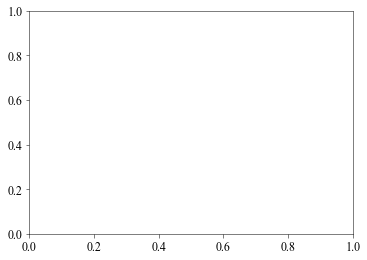

In [ ]:
## err history tmp

def sub(prefix=prefix, *,
        NN=NN,
        beta=beta,
        err_rho=err_rho,
        err_u=err_u,
        pp=pp,
):
    for N in NN:
        scaler = 2 # nx = 64 * scaler
    
        skip = 10 * (scaler//2) # ioprune in bindiff, ensemble_stat
        steps_per_fout = 10 * (scaler//2) * skip
        ioprune = 10 * scaler//2
        p = ioprune // skip
        xx = []
        nd = []
        ng = []
        kf = []
        ob = []
    
        
        def cal_tmean(rmse, *, last=8, p=p):
            return rmse[len(rmse)//last*(last-1) :: p].mean()
        
        bindiff_debug = False
        test_plots_e = 0
        
        for xyprune in pp:
            print(f'ens: {N}, xyprune: {xyprune}')
            xx.append(xyprune)
            
            # time
            fig, ax = plt.subplots()
            
            #pprefix = f'{prefix}/ens{N}_xyprune{xyprune}/beta{beta}' # beta scan
            #pprefix = f'{prefix}/ens{N}_xyprune{xyprune}_opt' # betaopt
            pprefix = f'{prefix}/ens{N}/xyprune{xyprune}/errrho_{err_rho}_erru{err_u}/beta{beta}'
            #pprefix = f'{prefix}/ens{N}/xyprune{xyprune}/err{err}/beta{beta}'
            test_plots_p = 0
            
            # ensemble
            try:
                f = np.loadtxt(f'{pprefix}/test_letkf{N}.csv', delimiter=',')
                rmse = f[:, 2]
                rmse[:] = rmse[:] * u0_factor * rmse_factor
                t = np.arange(len(rmse)) * steps_per_fout
                tmax = t.max()
                ax.plot(t[::p], rmse[::p], label=f'LETKF (En. mean)', color='C0')
                spread = f[:, 1] * u0_factor * rmse_factor * spread_factor(N)
                ax.plot(t[::p], spread[::p], label=f'LETKF (En. spread)', color='C2', )
                print(f' ensemble stat: rmse: {cal_tmean(rmse)}, spread: {cal_tmean(spread)}')
                kf.append(cal_tmean(rmse))
                test_plots_p += 1
                test_plots_e += 1
                ensemble_tsteps = len(rmse[::p])
            except:
                print(f'  error loading {pprefix}/test_letkf{N}.csv')
                kf.append(np.nan)
                pass
            
            # ensemble members
            for k in range(N):
                try:
                    rmse = np.loadtxt(f'{pprefix}/letkf{N}/test_cal_ens_{k}.csv', delimiter=',')[:, 1]
                    rmse[:] = rmse[:] * u0_factor * rmse_factor
                    if bindiff_debug:
                        rmse = rmse[::skip]
                    rmse_x = np.arange(len(rmse)) * steps_per_fout
                    label = 'LETKF (each member)' if k == 0 else None
                    ax.plot(rmse_x[::p], rmse[::p], label=label, color='C0', lw=1, alpha=1/np.sqrt(N))
                    if k == 0:
                        print(f' ensemble {k}: rmse: {cal_mean(rmse)}')
                except:
                    pass
            
            # nudging
            try:
                rmse = np.loadtxt(f'{pprefix}/test_cal_nudging.csv', delimiter=',')[:, 1]
                rmse[:] = rmse[:] * u0_factor * rmse_factor
                if bindiff_debug:
                    rmse = rmse[::skip]
                rmse_x = np.arange(len(rmse)) * steps_per_fout
                ax.plot(rmse_x[::p], rmse[::p], label=f'nudging', color='C1')
                print(f' nudging: rmse: {cal_tmean(rmse)}')
                ng.append(cal_tmean(rmse))
            except:
                print(f'  error loading {pprefix}/test_cal_nudging.csv')
                ng.append(np.nan)
                pass
        
            # obs
            try:
                rmse = np.loadtxt(f'{pprefix}/test_obs.csv', delimiter=',')[:, 1]
                rmse[:] = rmse[:] * u0_factor * rmse_factor
                if bindiff_debug:
                    rmse = rmse[::skip]
                rmse_x = np.arange(len(rmse)) * steps_per_fout
                ax.plot(rmse_x[::p], rmse[::p], label='observed', color='k', ls=':')
                print(f' observed: rmse: {cal_tmean(rmse)}')
                ob.append(cal_tmean(rmse))
            except:
                print(f'  error loading {pprefix}/test_obs.csv')
                ob.append(np.nan)
                pass
            
            # noda
            try:
                rmse = np.loadtxt(f'{pprefix}/test_cal_noda.csv', delimiter=',')[:, 1]
                rmse[:] = rmse[:] * u0_factor * rmse_factor
                if bindiff_debug:
                    rmse = rmse[::skip]
                rmse_x = np.arange(len(rmse)) * steps_per_fout
                ax.plot(rmse_x[::p], rmse[::p], label=f'no-DA', color='gray', ls='--')
                print(f' no-DA: rmse: {cal_tmean(rmse)}')
                nd.append(cal_tmean(rmse))
                noda_tsteps = len(rmse[::p])
            except:
                print(f'  error loading {pprefix}/test_cal_noda.csv')
                nd.append(np.nan)
                pass
            
            if ensemble_tsteps != noda_tsteps: ## maybe letkf is dead
                test_plots_p = 0
                kf[-1] = np.nan
            
            if test_plots_p > 0:
                def floor10(a):
                    cc = 10.0**np.arange(-10,2)
                    for c in cc:
                        if c < a and a < c*10:
                            return c
                    return None
                def ceil10(a):
                    cc = 10.0**np.arange(-10,2)
                    for c in cc:
                        if c < a and a < c*10:
                            return c*10
                    return None
                # labels
                ax.set_ylabel(r'$|\delta (t)|$')
                ax.set_xlabel(r'$t/\Delta t$')
                ax.set_yscale('log')
                ax.set_ylim(1e-3, 10)
                
                #ax.set_ylim(0,)
                ax.legend(loc='upper right')
                ax.set_xlim(0,tmax)#rmse_x.max())
                #ax.set_ylim(0,0.4)
                try:
                    plt.savefig(f'{pprefix}/errhist.pdf', bbox_inches='tight')
                    plt.savefig(f'{prefix}/fig/errhist_ens{N}_xyprune{xyprune}.pdf', bbox_inches='tight')
                except:
                    pass
                plt.show(fig)
            plt.close(fig)
        
        ## plot xx
        print(f'ens {N} plot:')
        if test_plots_e > 0:
            fig, ax = plt.subplots()
            ax.plot(xx[:len(kf)], kf, label='LETKF', marker='.')
            ax.plot(xx[:len(ng)], ng, label='Nudging', marker='.')
            #ax.plot(xx[:len(ob)], ob, label='observed', color='k', ls=':')
            ax.plot([np.min(xx), np.max(xx)], [ob[0], ob[0]], label='Observation', color='k', ls=':')
            ax.plot(xx[:len(nd)], nd, label='Non-DA', color='gray', ls='--')
            
            ax.set_ylabel(r'$|\delta (t)|$')
            ax.set_xlabel('$p$')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim(1e-3, 10)
            ax.legend()
            ax.set_xlim(1,)
            
            #plt.savefig(f'{prefix}/prune.pdf', bbox_inches='tight')
            plt.show(fig)
            plt.close(fig)
            
            ## save xx (to be used later)
            np.savez(f'{prefix}/fig/rmse_ens{N}', xx=xx, kf=kf, ng=ng, ob=ob, nd=nd)
        else:
            print('  no result data. skip.')
            
sub()

result/230207_fix_rloc_mat_betaopt


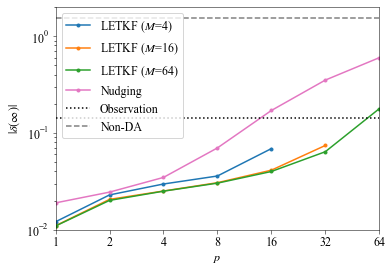

nudging: [0.01896653 0.02449031 0.03473856 0.07003402 0.17049334 0.35117767
 0.59801592]
letkf4: [0.01210751 0.02291591 0.02970427 0.03591953 0.06887331        nan
        nan]
letkf16: [0.01101245 0.02061285 0.02514598 0.03064437 0.04125697 0.07423382
        nan]
letkf64: [0.01094996 0.02011405 0.02504839 0.03031674 0.0399885  0.06396014
 0.17779035]


In [4]:
## load

def sub(prefix=prefix, *,
    NN=NN,
    pp=pp,
):
    print(prefix)
    kfkf = []
    for N in NN:
        npz = np.load(f'{prefix}/fig/rmse_ens{N}.npz')
        xx = npz['xx']
        ng = npz['ng']
        ob = npz['ob']
        ob[:] = ob[0]
        nd = npz['nd']
        kfkf.append(npz['kf'])
        
    fig, ax = plt.subplots()
    for i, N in enumerate(NN):
        ax.plot(xx[:len(kfkf[i])], kfkf[i], label=fr'LETKF ($M$={N})', marker='.', color=f'C{i}')
    ax.plot(xx[:len(ng)], ng, label='Nudging', color='C6', marker='.')
    #ax.plot(xx[:len(ob)], ob, label='Observation', color='k', ls=':')
    ax.plot([xx.min(), xx.max()], np.ones(2)*np.sqrt(2)*err_u, label='Observation', color='k', ls=':')
    ax.plot([xx.min(), xx.max()], [nd[0], nd[0]], label='Non-DA', color='gray', ls='--')
    
    ax.set_ylabel(r'$|\delta (\infty)|$')
    ax.set_xlabel(r'$p$')
    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    ax.set_ylim(0.01, 2)
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.legend()
    ax.set_xlim(np.min(pp), np.max(pp))
    ax.set_xticks(pp)
    ax.set_xticklabels([f'{p:.0f}' for p in pp])
    
    plt.savefig(f'{prefix}/fig/prune_many.pdf', bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
    
    print('nudging:', ng)
    for i, N in enumerate(NN):
        print(f'letkf{N}:', kfkf[i])
    
sub()

## plot err history over some Ne

xyprune: 1
 LETKF(4) rmse: 0.012180918397567568
 LETKF(16) rmse: 0.010838871044095267
 LETKF(64) rmse: 0.010769852708206247
 nudging: rmse: 0.02049472748655551
 no-DA: rmse: 1.4464604322926489


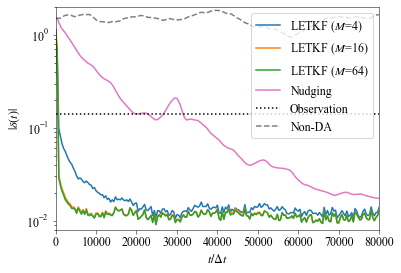

In [7]:
## err history whole

def sub():
    fig, ax = plt.subplots()

    xyprune = 1
    
    scaler = 4 # nx = 64 * scaler

    skip = 10 * (scaler//2) # ioprune in bindiff, ensemble_stat
    steps_per_fout = 10 * (scaler//2) * skip
    ioprune = 10 * scaler//2
    p = ioprune // skip
    xx = []
    nd = []
    ng = []
    kf = []
    ob = []
    
    bindiff_debug = False
    
    def cal_tmean(rmse, *, last=4, p=p):
        return rmse[len(rmse)//last*(last-1) :: p].mean()

    print(f'xyprune: {xyprune}')
    xx.append(xyprune)
        
    test_plots = 0

    # ensemble
    for i, N in enumerate(NN):
        pprefix = f'{prefix}/ens{N}/xyprune{xyprune}/errrho_{err_rho}_erru{err_u}/beta{beta}'
        try:
            f = np.loadtxt(f'{pprefix}/test_letkf{N}.csv', delimiter=',')
            rmse = f[:, 2]
            rmse[:] = rmse[:] * u0_factor * rmse_factor
            t = np.arange(len(rmse)) * steps_per_fout
            tmax = t.max()
            ax.plot(t[::p], rmse[::p], label=rf'LETKF ($M$={N})', color=f'C{i}')
            print(f' LETKF({N}) rmse: {cal_tmean(rmse)}')
            kf.append(cal_tmean(rmse))
            test_plots += 1
        except:
            print(f'error loading {pprefix}/test_letkf{N}.csv', file=sys.stderr)
            kf.append(np.nan)
            raise

    # others
    pprefix = f'{prefix}/ens64/xyprune{xyprune}/errrho_{err_rho}_erru{err_u}/beta{beta}' # betaopt
    # nudging
    try:
        rmse = np.loadtxt(f'{pprefix}/test_cal_nudging.csv', delimiter=',')[:, 1]
        rmse[:] = rmse[:] * u0_factor * rmse_factor
        if bindiff_debug:
            rmse = rmse[::skip]
        rmse_x = np.arange(len(rmse)) * steps_per_fout
        ax.plot(rmse_x[::p], rmse[::p], label=f'Nudging', color='C6')
        print(f' nudging: rmse: {cal_tmean(rmse)}')
        ng.append(cal_tmean(rmse))
        test_plots += 1
    except:
        print(f'error loading {pprefix}/test_cal_nudging.csv', file=sys.stderr)
        ng.append(np.nan)
        pass
    
    # obs
    ax.plot(rmse_x[::p], err_u*rmse_factor*np.ones(len(rmse_x[::p])), color='k', ls=':', label='Observation')
    
    # noda
    try:
        rmse = np.loadtxt(f'{pprefix}/test_cal_noda.csv', delimiter=',')[:, 1]
        rmse[:] = rmse[:] * u0_factor * rmse_factor
        if bindiff_debug:
            rmse = rmse[::skip]
        rmse_x = np.arange(len(rmse)) * steps_per_fout
        ax.plot(rmse_x[::p], rmse[::p], label=f'Non-DA', color='gray', ls='--')
        print(f' no-DA: rmse: {cal_tmean(rmse)}')
        nd.append(cal_tmean(rmse))
        test_plots += 1
    except:
        print(f'error loading {pprefix}/test_cal_noda.csv', file=sys.stderr)
        nd.append(np.nan)
        pass
        
    if test_plots > 0:
        # labels
        ax.set_ylabel(r'$|\delta (t)|$')
        ax.set_xlabel(r'$t/\Delta t$')
        ax.set_yscale('log')
        ax.set_ylim(8e-3, 2)
        #ax.set_ylim(0,)
        ax.legend(loc='upper right')
        ax.set_xlim(0,tmax)#rmse_x.max())
        #ax.set_xticks([0,5000,10000,15000,20000])
        #ax.set_ylim(0,0.4)
        try:
            plt.savefig(f'{prefix}/fig/errhist_MM_p{xyprune}.pdf', bbox_inches='tight')
        except:
            pass
        plt.show(fig)
    plt.close(fig)

sub()

In [4]:
## plot beta

def sub(prefix, *, 
        N=4,
        xyprune=1,
        beta_list = [1, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1,
                     1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2,
                     1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3,
                     1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4,
                     1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5,
                    ],
        rloc=np.nan,
        val_type='u', 
        is_plot=False,
        is_plot2=False,
        ylim=None,
        err_rho, err_u,
        check_noda_len=True,
):
    print(f'{val_type}: N={N:2d}, p={xyprune}, rloc={rloc}, err_rho={err_rho}, err_u={err_u}: ', end='')
    shape = (len(beta_list))
    rmse_abs = np.ones(shape) * np.nan
    rmse_obs = np.ones(shape) * np.nan
    rmse_sp  = np.ones(shape) * np.nan
    
    scaler = 2 # nx = 64 * scaler
    skip = 10 * (scaler//2) # ioprune in bindiff, ensemble_stat
    steps_per_fout = 10 * (scaler//2) * skip
    ioprune = 10 * scaler//2
    p = ioprune // skip
    rmse_col = 2 if val_type=='u' else 4
    spread_col = 1 if val_type=='u' else 3
    u0_factor_ = u0_factor if val_type=='u' else 1
    rmse_factor_ = rmse_factor if val_type=='u' else 1
    
    fig, ax = plt.subplots()
    test_plots_e = 0
    
    for ibeta in range(len(beta_list)):
        beta = beta_list[ibeta]
        rmse_o = err_u if val_type=='u' else err_rho
        rmse_o *= u0_factor_ * rmse_factor_
        
        def cal_tmean(rmse, *, last=4, p=p):
            return rmse[len(rmse)//last*(last-1) :: p].mean()
            #return rmse[-1]
                
        if is_plot2:
            print(f'err_rho: {err_rho}, err_u: {err_u}, beta: {beta}')
        
        # plots for time hitory
        plt.close(fig)
        fig, ax = plt.subplots()
        
        #pprefix = f'{prefix}/ens{N}_xyprune{xyprune}_rloc{rloc}_beta{beta}/errrho{err_rho}_erru{err_u}' # err scan
        pprefix = f'{prefix}/ens{N}/xyprune{xyprune}/errrho_{err_rho}_erru{err_u}/beta{beta}' # v1231
        test_plots_p = 0
        
        # ensemble
        try:
            f = np.loadtxt(f'{pprefix}/test_letkf{N}.csv', delimiter=',')
            if check_noda_len:
                fn = np.loadtxt(f'{pprefix}/test_cal_noda.csv', delimiter=',')
                assert f.shape[0] == fn.shape[0], 'invalid result length. maybe LETKF died??'
            rmse = f[:, rmse_col]
            spread = f[:, spread_col]
            rmse *= u0_factor_ * rmse_factor_
            spread *= u0_factor_ * rmse_factor_ * spread_factor(N)
            t = np.arange(len(rmse)) * steps_per_fout
            tmax = t.max()
            if is_plot2:
                ax.plot(t[::p], rmse[::p], label=f'LETKF (En. mean)', color='C0')
                ax.plot(t[::p], spread[::p], label=f'LETKF (En. spread)', color='C2', )
                print(f' ensemble stat: rmse: {cal_tmean(rmse)}, spread: {cal_tmean(spread)}')
            test_plots_p += 1
            test_plots_e += 1
        except:
            if is_plot2:
                print(f'  error loading {pprefix}/test_letkf{N}.csv')
            rmse = np.nan * np.ones(1)
            spread = np.nan * np.ones(1)
            
        # obs
        if is_plot2:
            try:
                ax.plot([t.min(),t.max()], rmse_o*u0_factor_*rmse_factor_*np.ones(2), label='Observation', ls=':', color='k',)
            except:
                pass
            
        rmse_obs[ibeta] = rmse_o
        rmse_abs[ibeta] = cal_tmean(rmse)
        rmse_sp [ibeta] = cal_tmean(spread)
        
        if is_plot2 and test_plots_p > 0:
            # labels
            ax.set_ylabel(r'$|\delta (t)|$')
            ax.set_xlabel(r'$t/\Delta t$')
            ax.set_yscale('log')
            #ax.set_ylim(1e-2, )
            #ax.set_ylim(0,)
            ax.legend(loc='upper right')
            ax.set_xlim(0,)#rmse_x.max())
            #ax.set_ylim(0,0.4)
            try:
                fig.savefig(f'{pprefix}/errhist.pdf', bbox_inches='tight')
            except:
                pass
            plt.show(fig)
        plt.close(fig)
            
    ## plot total
    if test_plots_e > 0:
        where_min_i = np.nanargmin(rmse_abs)
        print(f'where min: β={beta_list[where_min_i]}, rmse={rmse_abs[where_min_i]}')
        fig, ax = plt.subplots()
        ax.plot(beta_list, rmse_abs, label=rf'En. mean RMSE', color=f'C0', marker='.')
        ax.plot(beta_list, rmse_sp, label='En. spread RMS', color=f'C0', lw=1)
        ax.plot(beta_list, rmse_o*np.ones(len(beta_list)), label='Obs. noise RMS', color=f'k', ls=':')
        ax.set_xlabel(r'$\beta$')
        ax.set_ylabel(r'Error or Spread')
        ax.set_xlim(np.min(beta_list), np.max(beta_list))
        if ylim is None:
            def floor10(a):
                cc = 10.0**np.arange(-10,2)
                for c in cc:
                    if c < a and a < c*10:
                        return c
                return None
            def ceil10(a):
                cc = 10.0**np.arange(-10,2)
                for c in cc:
                    if c < a and a < c*10:
                        return c*10
                return None
            ylim = [floor10(np.nanmin([np.nanmin(rmse_obs), np.nanmin(rmse_abs), np.nanmin(rmse_sp)])),
                    1]##np.max([1.0, ceil10(np.nanmax([np.nanmax(rmse_obs), np.nanmax(rmse_abs), np.nanmax(rmse_sp)]))])]
        ax.set_ylim(ylim)
        #ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        fig.savefig(f'{prefix}/fig/beta_test_{val_type}_xyprune{xyprune}_N{N}.pdf', bbox_inches='tight')
        if is_plot:
            plt.show(fig)
        plt.close(fig)
        print()
    else:
        print('no valid results found')
# enddef

%mkdir -p ../result/230207_fix_rloc_mat__seek_beta/fig
NN = [4, 16, 64]
vals = ['u', ]
pp = [1,2,4,8,16,32,64]
err_rho = 0.01
err_u = 0.1
    
for N, p, val in itertools.product(NN, pp, vals):
    sub('../result/230220_fp64', is_plot=True, is_plot2=False, xyprune=p, val_type=val, N=N, err_rho=err_rho, err_u=err_u, )


u: N= 4, p=1, rloc=nan, err_rho=0.01, err_u=0.1: no valid results found
u: N= 4, p=2, rloc=nan, err_rho=0.01, err_u=0.1: no valid results found
u: N= 4, p=4, rloc=nan, err_rho=0.01, err_u=0.1: no valid results found
u: N= 4, p=8, rloc=nan, err_rho=0.01, err_u=0.1: no valid results found
u: N= 4, p=16, rloc=nan, err_rho=0.01, err_u=0.1: 


KeyboardInterrupt



<Figure size 417.6x295.2 with 0 Axes>